In [ ]:
#pip install pandas numpy matplotlib seaborn scikit xgboost shap tqdm joblib scipy statsmodels reportlab faker umap-learn
#pip install -r requirements.txt

## Generate Data

## Try 3

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Dict, Any
from dataclasses import dataclass, field
import logging
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

@dataclass
class AnalysisConfig:
    data_path: str
    label_column: str
    feature_columns: List[str]
    date_column: str
    loco_cv_columns: List[str]
    test_size: float = 0.2
    random_state: int = 42

class FraudDetectionFramework:
    def __init__(self, df: pd.DataFrame, config: AnalysisConfig):
        self.df = df
        self.config = config
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.preprocessor: Optional[ColumnTransformer] = None
        self.models = {
            'logistic': LogisticRegression(random_state=config.random_state),
            'random_forest': RandomForestClassifier(random_state=config.random_state),
            'gradient_boosting': GradientBoostingClassifier(random_state=config.random_state),
            'svm': SVC(probability=True, random_state=config.random_state),
            'xgboost': XGBClassifier(random_state=config.random_state)
        }
        self.logger = self._setup_logger()

    def _setup_logger(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        return logging.getLogger(__name__)

    def preprocess_data(self):
        self.X = self.df[self.config.feature_columns]
        self.y = self.df[self.config.label_column]
        
        # Identify which LOCO CV columns are present in feature columns
        loco_cv_columns_present = [col for col in self.config.loco_cv_columns if col in self.X.columns]
        
        numeric_features = self.X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = self.X.select_dtypes(include=['object', 'category']).columns
        categorical_features = [col for col in categorical_features if col not in loco_cv_columns_present]
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        
        X_transformed = self.preprocessor.fit_transform(self.X.drop(columns=loco_cv_columns_present, errors='ignore'))
        
        feature_names = (numeric_features.tolist() + 
                         self.preprocessor.named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features).tolist())
        
        self.X = pd.DataFrame(X_transformed, columns=feature_names)
        self.X[loco_cv_columns_present] = self.df[loco_cv_columns_present]

    def add_unsupervised_features(self):
        # K-means clustering
        kmeans = KMeans(n_clusters=5, random_state=self.config.random_state)
        self.X['kmeans_cluster'] = kmeans.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))
        
        # Isolation Forest
        iso_forest = IsolationForest(random_state=self.config.random_state)
        self.X['isolation_forest_score'] = iso_forest.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))

    def remove_collinear_features(self, threshold=0.9):
        # Exclude LOCO CV columns from collinearity check
        X_corr = self.X.drop(columns=self.config.loco_cv_columns, errors='ignore')
        corr_matrix = X_corr.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        self.X = self.X.drop(to_drop, axis=1)

    def perform_pca(self, n_components=0.95):
        # Exclude LOCO CV columns from PCA
        pca_columns = [col for col in self.X.columns if col not in self.config.loco_cv_columns]
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(self.X[pca_columns])
        
        # Create new DataFrame with PCA results and LOCO CV columns
        self.X = pd.DataFrame(pca_result, columns=[f'PC_{i}' for i in range(pca_result.shape[1])])
        self.X[self.config.loco_cv_columns] = self.df[self.config.loco_cv_columns]

    def regular_train_test_split(self):
        X = self.X.drop(columns=self.config.loco_cv_columns, errors='ignore')
        return train_test_split(X, self.y, test_size=self.config.test_size, random_state=self.config.random_state)

    def loco_cv(self, model):
        loco_results = {}
        
        for column in self.config.loco_cv_columns:
            if column not in self.X.columns:
                continue
            column_results = {}
            unique_values = self.X[column].unique()
            for value in unique_values:
                train_mask = self.X[column] != value
                test_mask = self.X[column] == value
                
                X_train, X_test = self.X[train_mask], self.X[test_mask]
                y_train, y_test = self.y[train_mask], self.y[test_mask]
                
                X_train = X_train.drop(columns=self.config.loco_cv_columns, errors='ignore')
                X_test = X_test.drop(columns=self.config.loco_cv_columns, errors='ignore')
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1]
                
                metrics = self.evaluate_model(y_test, y_pred, y_prob)
                column_results[value] = metrics
            
            loco_results[column] = column_results
        
        return loco_results
    
    def time_based_split(self, split_ratio=0.8):
        self.df[self.config.date_column] = pd.to_datetime(self.df[self.config.date_column])
        split_date = self.df[self.config.date_column].quantile(split_ratio)
        
        train_mask = self.df[self.config.date_column] <= split_date
        test_mask = self.df[self.config.date_column] > split_date
        
        X_train = self.X[train_mask].drop(columns=self.config.loco_cv_columns, errors='ignore')
        X_test = self.X[test_mask].drop(columns=self.config.loco_cv_columns, errors='ignore')
        y_train = self.y[train_mask]
        y_test = self.y[test_mask]
        
        return X_train, X_test, y_train, y_test

    def evaluate_model(self, y_true, y_pred, y_prob):
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'roc_auc': roc_auc_score(y_true, y_prob),
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

    def run_analysis(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        regular_results = []
        loco_cv_results = []
        
        feature_configs = [
            ('original', lambda: None),
            ('unsupervised', self.add_unsupervised_features),
            ('remove_collinear', self.remove_collinear_features),
            ('pca', self.perform_pca)
        ]
        
        split_configs = [
            ('regular', self.regular_train_test_split),
            ('loco_cv', lambda: (self.X, self.y, None, None)),
            ('time_50_50', lambda: self.time_based_split(0.5)),
            ('time_80_20', lambda: self.time_based_split(0.8))
        ]
        
        for feature_name, feature_func in feature_configs:
            self.preprocess_data()
            feature_func()
            
            for split_name, split_func in split_configs:
                X_train, X_test, y_train, y_test = split_func()
                
                for model_name, model in self.models.items():
                    if split_name == 'loco_cv':
                        loco_metrics = self.loco_cv(model)
                        for column, column_results in loco_metrics.items():
                            for category, metrics in column_results.items():
                                loco_cv_results.append({
                                    'feature_config': feature_name,
                                    'model': model_name,
                                    'loco_column': column,
                                    'loco_category': category,
                                    **metrics
                                })
                    else:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        y_prob = model.predict_proba(X_test)[:, 1]
                        eval_results = self.evaluate_model(y_test, y_pred, y_prob)
                        regular_results.append({
                            'feature_config': feature_name,
                            'split': split_name,
                            'model': model_name,
                            **eval_results
                        })
        
        regular_df = pd.DataFrame(regular_results)
        loco_cv_df = pd.DataFrame(loco_cv_results)
        
        return regular_df, loco_cv_df

# # Usage example remains the same
# if __name__ == "__main__":
#     df = pd.read_csv("identity_fraud_data.csv")
#     df = df[0:1000]
#     threshold = df['fraud_probability'].quantile(0.95)  # Use 95th percentile as threshold
#     df['fraud_cat1'] = np.random.choice(['A', 'B', 'C'], df.shape[0])
#     df['fraud_cat2'] = np.random.choice(['X', 'Y', 'Z'], df.shape[0])

#     df['fraud_binary'] = (df['fraud_probability'] > threshold).astype(int)

#     config = AnalysisConfig(
#         data_path="identity_fraud_data.csv",
#         label_column="fraud_binary",
#         feature_columns=[col for col in df.columns if col not in ['transaction_date', 'user_id', 'fraud_probability', 'fraud_cat1', 'fraud_cat2', 'fraud_binary']],
#         loco_cv_columns=['fraud_cat1', 'fraud_cat2'],
#         date_column='transaction_date',
#     )

#     analyzer = FraudDetectionFramework(df, config)
#     regular_results_df, loco_cv_results_df = analyzer.run_analysis()

#     print("Regular Results:")
#     print(regular_results_df)

#     print("\nLOCO CV Results:")
#     print(loco_cv_results_df)

In [111]:
#label 2 columns for loco CV, randomly split into 3 groups each for each fraud type


In [100]:
df.head()

,transaction_date,user_id,age_1,login_attempts_2,days_since_registration_3,document_upload_count_4,ip_reputation_score_5,device_age_days_6,account_age_days_7,failed_login_count_8,...,multiple_account_creation_5,rapid_profile_changes_6,known_fraud_patterns_7,suspicious_email_domain_8,device_fingerprint_match_9,ip_velocity_check_10,fraud_probability,fraud_cat1,fraud_cat2,fraud_binary
0,2022-01-01 00:00:00.000000000,c2df9610-f5ac-43b9-ae6c-835bea54104b,25,6,850,4,88.0,1204,948,8,...,1,0,0,0,0,0,0.124550,A,Y,0
1,2022-01-01 01:44:59.189918991,9fa1b6d6-8536-43be-89f4-8a4c3f9b0479,31,5,3039,0,98.0,650,1047,12,...,1,0,0,0,0,0,0.097599,B,X,0
2,2022-01-01 03:29:58.379837983,458a7ab6-b0f2-4652-bcff-6130132865c5,69,6,2378,5,9.0,881,111,6,...,0,0,0,0,0,0,0.066241,B,Z,0
3,2022-01-01 05:14:57.569756975,a145040c-eb84-4f9c-9f60-4265cb5a1544,31,3,675,3,15.0,1455,43,19,...,0,0,0,0,0,0,0.128420,B,X,0
4,2022-01-01 06:59:56.759675967,e92c41ea-a2db-4b67-a73e-61ce474a98d1,58,9,91,4,18.0,291,1584,5,...,0,0,0,0,0,0,0.101369,C,Z,0


In [102]:
[col for col in df.columns if col.startswith('heuristic')]

[]

In [112]:
# Load your data
df = pd.read_csv("identity_fraud_data.csv")
df = df[0:5000]
df['fraud_cat1'] = np.random.choice(['A', 'B', 'C'], df.shape[0])
df['fraud_cat2'] = np.random.choice(['X', 'Y', 'Z'], df.shape[0])
threshold = df['fraud_probability'].quantile(0.95)  # Use 95th percentile as threshold
#df['fraud_cat1'] = np.random.choice([1,2,3], df.shape[0])
#df['fraud_cat2'] = np.random.choice([5,6,7], df.shape[0])

df['fraud_binary'] = (df['fraud_probability'] > threshold).astype(int)

config = AnalysisConfig(
    data_path="identity_fraud_data.csv",
    label_column="fraud_binary",  # This should be your continuous fraud probability column
    feature_columns=[col for col in df.columns if not col.startswith('heuristic') and col not in ['transaction_date', 'user_id', 'fraud_probability','fraud_cat1', 'fraud_cat2']],
    #heuristic_columns=[col for col in df.columns if col.startswith('heuristic')],
    loco_cv_columns=['fraud_cat1', 'fraud_cat2'],
    date_column='transaction_date',
    #test_start_date="2023-07-01"
)
# model_config = ModelConfig()
# drift_config = DriftConfig()

# analyzer = FraudDetectionFramework(df, config, model_config, drift_config)
# analyzer.run_analysis()

analyzer = FraudDetectionFramework(df, config)
regular_results_df, loco_cv_results_df = analyzer.run_analysis()

print("Regular Results:")
display(regular_results_df)

print("\nLOCO CV Results:")
display(loco_cv_results_df)


Regular Results:


,feature_config,split,model,accuracy,precision,recall,f1,f2,roc_auc,confusion_matrix
0,original,regular,logistic,0.9550,0.0,0.0,0.0,0.0,0.501966,"[[955, 0], [45, 0]]"
1,original,regular,random_forest,0.9550,0.0,0.0,0.0,0.0,0.502455,"[[955, 0], [45, 0]]"
2,original,regular,gradient_boosting,0.9530,0.0,0.0,0.0,0.0,0.569703,"[[953, 2], [45, 0]]"
3,original,regular,svm,0.9550,0.0,0.0,0.0,0.0,0.522978,"[[955, 0], [45, 0]]"
4,original,regular,xgboost,0.9550,0.0,0.0,0.0,0.0,0.479348,"[[955, 0], [45, 0]]"
5,original,time_50_50,logistic,0.9520,0.0,0.0,0.0,0.0,0.484443,"[[2380, 0], [120, 0]]"
6,original,time_50_50,random_forest,0.9520,0.0,0.0,0.0,0.0,0.477176,"[[2380, 0], [120, 0]]"
7,original,time_50_50,gradient_boosting,0.9484,0.0,0.0,0.0,0.0,0.486684,"[[2371, 9], [120, 0]]"
8,original,time_50_50,svm,0.9520,0.0,0.0,0.0,0.0,0.486310,"[[2380, 0], [120, 0]]"
9,original,time_50_50,xgboost,0.9520,0.0,0.0,0.0,0.0,0.495676,"[[2380, 0], [120, 0]]"



LOCO CV Results:


,feature_config,model,loco_column,loco_category,accuracy,precision,recall,f1,f2,roc_auc,confusion_matrix
0,pca,logistic,fraud_cat1,A,0.951190,0.0,0.0,0.0,0.0,0.429813,"[[1598, 0], [82, 0]]"
1,pca,logistic,fraud_cat1,C,0.947942,0.0,0.0,0.0,0.0,0.466260,"[[1566, 0], [86, 0]]"
2,pca,logistic,fraud_cat1,B,0.950839,0.0,0.0,0.0,0.0,0.511180,"[[1586, 0], [82, 0]]"
3,pca,logistic,fraud_cat2,Z,0.955936,0.0,0.0,0.0,0.0,0.441439,"[[1562, 0], [72, 0]]"
4,pca,logistic,fraud_cat2,Y,0.949271,0.0,0.0,0.0,0.0,0.470982,"[[1628, 0], [87, 0]]"
5,pca,logistic,fraud_cat2,X,0.944882,0.0,0.0,0.0,0.0,0.504790,"[[1560, 0], [91, 0]]"
6,pca,random_forest,fraud_cat1,A,0.951190,0.0,0.0,0.0,0.0,0.423063,"[[1598, 0], [82, 0]]"
7,pca,random_forest,fraud_cat1,C,0.947942,0.0,0.0,0.0,0.0,0.493050,"[[1566, 0], [86, 0]]"
8,pca,random_forest,fraud_cat1,B,0.950839,0.0,0.0,0.0,0.0,0.452861,"[[1586, 0], [82, 0]]"
9,pca,random_forest,fraud_cat2,Z,0.955936,0.0,0.0,0.0,0.0,0.471795,"[[1562, 0], [72, 0]]"


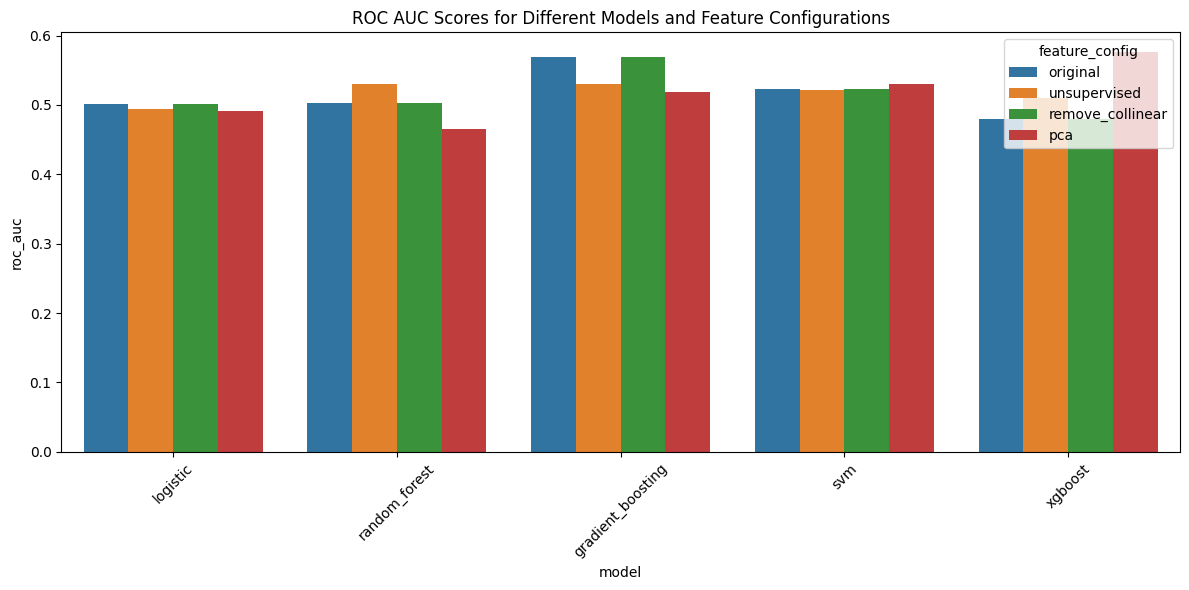

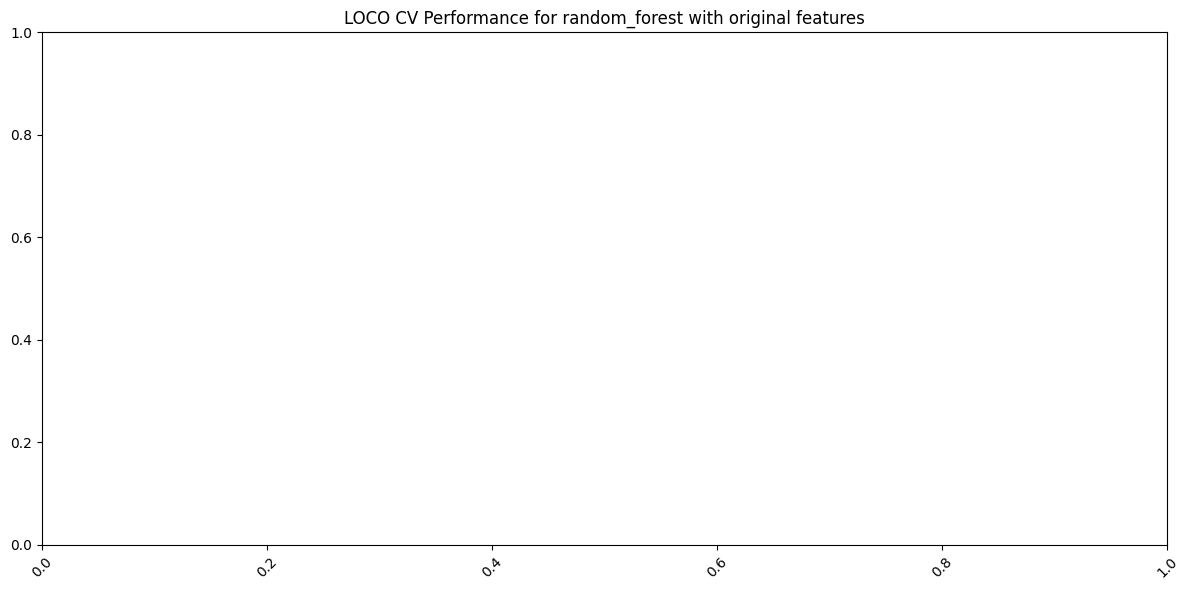

In [113]:
# You can now easily analyze and visualize the results using pandas and matplotlib/seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plot ROC AUC scores for different models and feature configs
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='roc_auc', hue='feature_config', data=regular_results_df[regular_results_df['split'] == 'regular'])
plt.title('ROC AUC Scores for Different Models and Feature Configurations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Example: Plot LOCO CV performance for a specific model and feature config
model_name = 'random_forest'
feature_config = 'original'
plt.figure(figsize=(12, 6))
sns.boxplot(x='loco_column', y='roc_auc', hue='loco_category', 
            data=loco_cv_results_df[(loco_cv_results_df['model'] == model_name) & 
                                    (loco_cv_results_df['feature_config'] == feature_config)])
plt.title(f'LOCO CV Performance for {model_name} with {feature_config} features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
#set pandas row limit
pd.set_option('display.max_rows', 500)

2024-09-09 16:42:01,702 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-09 16:42:01,706 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


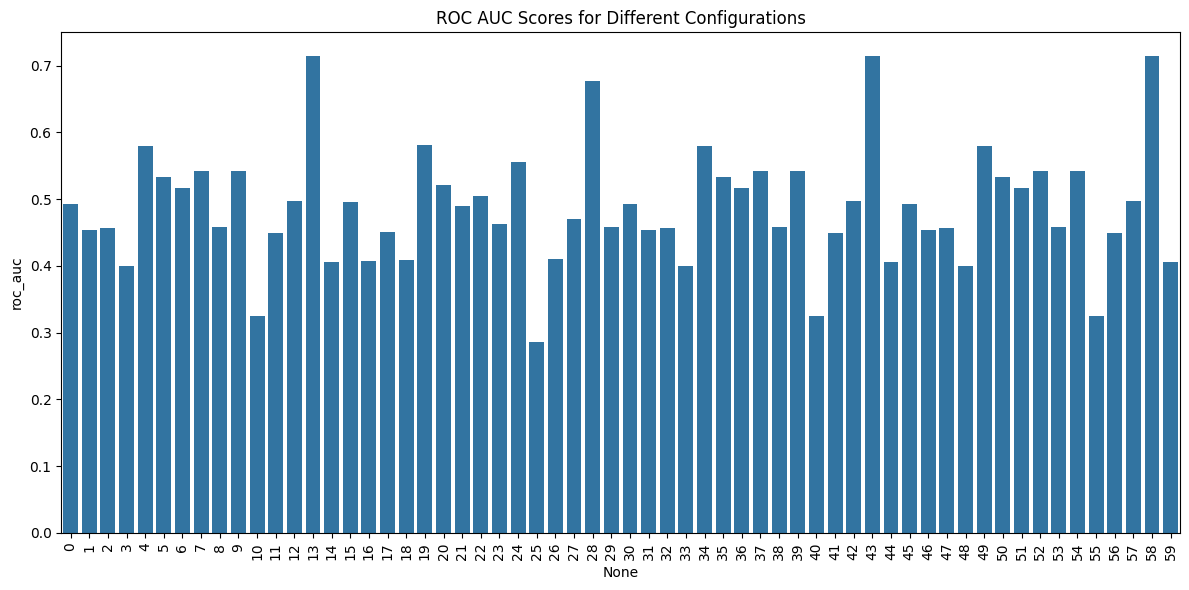

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot ROC AUC scores for different configurations
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='roc_auc', data=results_df)
plt.xticks(rotation=90)
plt.title('ROC AUC Scores for Different Configurations')
plt.tight_layout()
plt.show()

# Plot confusion matrices for a specific configuration
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# for config in results_df.index:
#     if 'confusion_matrix' in results_df.loc[config]:
#         plot_confusion_matrix(results_df.loc[config, 'confusion_matrix'], f'Confusion Matrix - {config}')

## Try 4

This was a combo of 2 + 3, 3 is the most effective one so far for the pure modeling and LOCO CV analysis

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Dict, Any
from dataclasses import dataclass
import logging
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
import seaborn as sns
import shap
import umap
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

@dataclass
class AnalysisConfig:
    data_path: str
    label_column: str
    feature_columns: List[str]
    date_column: str
    loco_cv_columns: List[str]
    test_size: float = 0.2
    random_state: int = 42
    variance_threshold: float = 0.01
    correlation_threshold: float = 0.95
    pca_n_components: float = 0.95
    n_clusters: int = 5

class EnhancedFraudDetectionFramework:
    def __init__(self, df: pd.DataFrame, config: AnalysisConfig):
        self.df = df
        self.config = config
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.X_train: Optional[pd.DataFrame] = None
        self.X_test: Optional[pd.DataFrame] = None
        self.y_train: Optional[pd.Series] = None
        self.y_test: Optional[pd.Series] = None
        self.preprocessor: Optional[ColumnTransformer] = None
        self.models = {
            'logistic': LogisticRegression(random_state=config.random_state),
            'random_forest': RandomForestClassifier(random_state=config.random_state),
            'gradient_boosting': GradientBoostingClassifier(random_state=config.random_state),
            'svm': SVC(probability=True, random_state=config.random_state),
            'xgboost': XGBClassifier(random_state=config.random_state)
        }
        self.best_models: Dict[str, Any] = {}
        self.feature_importances: Dict[str, pd.DataFrame] = {}
        self.shap_values: Dict[str, Any] = {}
        self.clustering_results: Dict[str, np.ndarray] = {}
        self.dim_reduction_results: Dict[str, np.ndarray] = {}
        self.anomaly_results: Dict[str, np.ndarray] = {}
        self.logger = self._setup_logger()

    def _setup_logger(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        return logging.getLogger(__name__)

    def preprocess_data(self):
        self.X = self.df[self.config.feature_columns]
        self.y = self.df[self.config.label_column]
        
        numeric_features = self.X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = self.X.select_dtypes(include=['object', 'category']).columns
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        
        X_transformed = self.preprocessor.fit_transform(self.X)
        
        feature_names = (numeric_features.tolist() + 
                         self.preprocessor.named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features).tolist())
        
        self.X = pd.DataFrame(X_transformed, columns=feature_names)

    def explore_data(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.y, kde=True)
        plt.title("Distribution of Fraud Probability")
        plt.xlabel("Fraud Probability")
        plt.ylabel("Frequency")
        plt.savefig("fraud_probability_distribution.png")
        plt.close()

        corr_matrix = self.X.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
        plt.title("Feature Correlation Heatmap")
        plt.savefig("feature_correlation_heatmap.png")
        plt.close()

        target_corr = self.X.apply(lambda x: stats.spearmanr(x, self.y)[0])
        top_corr = target_corr.abs().sort_values(ascending=False).head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_corr.values, y=top_corr.index)
        plt.title("Top 10 Features Correlated with Fraud Probability")
        plt.xlabel("Spearman Correlation")
        plt.savefig("top_correlated_features.png")
        plt.close()

    def perform_unsupervised_analysis(self):
        # PCA
        pca = PCA(n_components=self.config.pca_n_components)
        X_pca = pca.fit_transform(self.X)
        self.dim_reduction_results['pca'] = X_pca

        # t-SNE
        tsne = TSNE(n_components=2, random_state=self.config.random_state)
        X_tsne = tsne.fit_transform(self.X)
        self.dim_reduction_results['tsne'] = X_tsne

        # UMAP
        umap_reducer = umap.UMAP(random_state=self.config.random_state)
        X_umap = umap_reducer.fit_transform(self.X)
        self.dim_reduction_results['umap'] = X_umap

        # K-means clustering
        kmeans = KMeans(n_clusters=self.config.n_clusters, random_state=self.config.random_state)
        self.clustering_results['kmeans'] = kmeans.fit_predict(X_pca)

        # Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=self.config.n_clusters)
        self.clustering_results['hierarchical'] = hierarchical.fit_predict(X_pca)

        # Isolation Forest for anomaly detection
        iso_forest = IsolationForest(contamination=0.1, random_state=self.config.random_state)
        self.anomaly_results['isolation_forest'] = iso_forest.fit_predict(X_pca)

    def visualize_unsupervised_results(self):
        for dim_reduction_name, dim_reduction_result in self.dim_reduction_results.items():
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(dim_reduction_result[:, 0], dim_reduction_result[:, 1], c=self.y, cmap='viridis')
            plt.colorbar(scatter)
            plt.title(f'{dim_reduction_name.upper()} visualization')
            plt.xlabel(f'{dim_reduction_name} component 1')
            plt.ylabel(f'{dim_reduction_name} component 2')
            plt.savefig(f'{dim_reduction_name}_visualization.png')
            plt.close()

        for clustering_name, clustering_result in self.clustering_results.items():
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(self.dim_reduction_results['pca'][:, 0], self.dim_reduction_results['pca'][:, 1], c=clustering_result, cmap='viridis')
            plt.colorbar(scatter)
            plt.title(f'{clustering_name.capitalize()} clustering')
            plt.xlabel('PCA component 1')
            plt.ylabel('PCA component 2')
            plt.savefig(f'{clustering_name}_clustering.png')
            plt.close()

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(self.dim_reduction_results['pca'][:, 0], self.dim_reduction_results['pca'][:, 1], c=self.anomaly_results['isolation_forest'], cmap='viridis')
        plt.colorbar(scatter)
        plt.title('Isolation Forest Anomaly Detection')
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')
        plt.savefig('isolation_forest_anomalies.png')
        plt.close()

    def remove_collinear_features(self):
        corr_matrix = self.X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.config.correlation_threshold)]
        self.X = self.X.drop(to_drop, axis=1)

    def perform_pca(self):
        pca = PCA(n_components=self.config.pca_n_components)
        X_pca = pca.fit_transform(self.X)
        return pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(X_pca.shape[1])])

    def add_unsupervised_features(self):
        self.X['kmeans_cluster'] = self.clustering_results['kmeans']
        self.X['hierarchical_cluster'] = self.clustering_results['hierarchical']
        self.X['isolation_forest_score'] = self.anomaly_results['isolation_forest']

    def regular_train_test_split(self):
        return train_test_split(self.X, self.y, test_size=self.config.test_size, random_state=self.config.random_state)

    def time_based_split(self, split_ratio):
        self.df[self.config.date_column] = pd.to_datetime(self.df[self.config.date_column])
        split_date = self.df[self.config.date_column].quantile(split_ratio)
        
        train_mask = self.df[self.config.date_column] <= split_date
        test_mask = self.df[self.config.date_column] > split_date
        
        X_train = self.X[train_mask]
        X_test = self.X[test_mask]
        y_train = self.y[train_mask]
        y_test = self.y[test_mask]
        
        return X_train, X_test, y_train, y_test

    def loco_cv(self, model, X, y):
        loco_results = {}
        
        for column in self.config.loco_cv_columns:
            if column not in X.columns:
                continue
            column_results = {}
            unique_values = X[column].unique()
            for value in unique_values:
                train_mask = X[column] != value
                test_mask = X[column] == value
                
                X_train, X_test = X[train_mask], X[test_mask]
                y_train, y_test = y[train_mask], y[test_mask]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1]
                
                metrics = self.evaluate_model(y_test, y_pred, y_prob)
                column_results[value] = metrics
            
            loco_results[column] = column_results
        
        return loco_results

    def evaluate_model(self, y_true, y_pred, y_prob):
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'roc_auc': roc_auc_score(y_true, y_prob),
            'pr_auc': average_precision_score(y_true, y_prob),
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

    def train_and_evaluate_models(self):
        feature_configs = [
            ('original', lambda: None),
            ('unsupervised', self.add_unsupervised_features),
            ('remove_collinear', self.remove_collinear_features),
            ('pca', self.perform_pca)
        ]
        
        split_configs = [
            ('regular', self.regular_train_test_split),
            ('loco_cv', lambda: (self.X, self.y, None, None)),
            ('time_50_50', lambda: self.time_based_split(0.5)),
            ('time_80_20', lambda: self.time_based_split(0.8))
        ]

        results = []
        loco_cv_results = []

        for feature_name, feature_func in feature_configs:
            X_temp = self.X.copy()
            feature_func()
            
            for split_name, split_func in split_configs:
                X_train, X_test, y_train, y_test = split_func()
                
                # Set self.X_train and self.X_test for the 'original' feature config and 'regular' split
                if feature_name == 'original' and split_name == 'regular':
                    self.X_train, self.X_test = X_train, X_test
                    self.y_train, self.y_test = y_train, y_test
                
                for model_name, model in self.models.items():
                    if split_name == 'loco_cv':
                        loco_metrics = self.loco_cv(model, X_temp, self.y)
                        for column, column_results in loco_metrics.items():
                            for category, metrics in column_results.items():
                                loco_cv_results.append({
                                    'feature_config': feature_name,
                                    'model': model_name,
                                    'loco_column': column,
                                    'loco_category': category,
                                    **metrics
                                })
                    else:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        y_prob = model.predict_proba(X_test)[:, 1]
                        eval_results = self.evaluate_model(y_test, y_pred, y_prob)
                        results.append({
                            'feature_config': feature_name,
                            'split': split_name,
                            'model': model_name,
                            **eval_results
                        })
                        
                        if feature_name == 'original' and split_name == 'regular':
                            self.best_models[model_name] = model
                            
                            if hasattr(model, 'feature_importances_'):
                                importances = model.feature_importances_
                            elif model_name == 'logistic':
                                importances = np.abs(model.coef_[0])
                            else:
                                importances = None
                            
                            if importances is not None:
                                self.feature_importances[model_name] = pd.DataFrame({
                                    'feature': X_train.columns,
                                    'importance': importances
                                }).sort_values('importance', ascending=False)
            
            self.X = X_temp  # Reset X to original state

        return pd.DataFrame(results), pd.DataFrame(loco_cv_results)

    def calculate_shap_values(self):
        if self.X_train is None or self.X_test is None:
            self.logger.warning("X_train or X_test is not set. Skipping SHAP value calculation.")
            return

        for name, model in self.best_models.items():
            self.logger.info(f"Calculating SHAP values for {name}...")
            
            if name in ['random_forest', 'gradient_boosting', 'xgboost']:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(self.X_test)
                if isinstance(shap_values, list):
                    shap_values = shap_values[1]
            elif name in ['logistic', 'svm']:
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(self.X_train, 100))
                shap_values = explainer.shap_values(self.X_test)
                if isinstance(shap_values, list):
                    shap_values = shap_values[1]
            else:
                self.logger.warning(f"SHAP values not implemented for {name}. Skipping...")
                continue
            
            self.shap_values[name] = shap_values
            
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, self.X_test, plot_type="bar", show=False)
            plt.title(f"SHAP Feature Importance - {name}")
            plt.tight_layout()
            plt.savefig(f"{name}_shap_importance.png")
            plt.close()

    def visualize_results(self, results_df):
        for model_name in self.models.keys():
            model_results = results_df[results_df['model'] == model_name]
            
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='feature_config', y='roc_auc', hue='split', data=model_results)
            plt.title(f'{model_name} - ROC AUC across configurations')
            plt.savefig(f'{model_name}_roc_auc_comparison.png')
            plt.close()
            
            if model_name in self.feature_importances:
                plt.figure(figsize=(10, 6))
                self.feature_importances[model_name].head(20).plot(x='feature', y='importance', kind='bar')
                plt.title(f'Top 20 Feature Importances - {model_name}')
                plt.tight_layout()
                plt.savefig(f"{model_name}_feature_importances.png")
                plt.close()

    def run_analysis(self):
        self.logger.info("Starting fraud detection analysis...")
        
        self.preprocess_data()
        self.explore_data()
        
        self.logger.info("Performing unsupervised analysis...")
        self.perform_unsupervised_analysis()
        self.visualize_unsupervised_results()
        
        self.logger.info("Training and evaluating models...")
        results_df, loco_cv_results_df = self.train_and_evaluate_models()
        
        #self.logger.info("Calculating SHAP values...")
        #self.calculate_shap_values()
        
        self.logger.info("Visualizing results...")
        self.visualize_results(results_df)
        
        self.logger.info("Analysis complete. Saving results...")
        results_df.to_csv('model_evaluation_results.csv', index=False)
        loco_cv_results_df.to_csv('loco_cv_results.csv', index=False)
        
        return results_df, loco_cv_results_df

# # Usage example
# if __name__ == "__main__":
#     # Load your DataFrame here
#     df = pd.read_csv("path_to_your_data.csv")
    
#     config = AnalysisConfig(
#         data_path="path_to_your_data.csv",
#         label_column="fraud_probability",
#         feature_columns=["feature1", "feature2", "feature3"],  # List your feature columns here
#         loco_cv_columns=["category1", "category2"],  # List your LOCO CV columns here
#         date_column="transaction_date",
#         test_size=0.2,
#         random_state=42,
#         variance_threshold=0.01,
#         correlation_threshold=0.95,
#         pca_n_components=0.95,
#         n_clusters=5
#     )
    
#     analyzer = EnhancedFraudDetectionFramework(df, config)
#     results_df, loco_cv_results_df = analyzer.run_analysis()
    
#     print("Analysis complete. Results saved to 'model_evaluation_results.csv' and 'loco_cv_results.csv'")

In [116]:
# Load your data
df = pd.read_csv("identity_fraud_data.csv")
df = df[0:1000]
df['fraud_cat1'] = np.random.choice(['A', 'B', 'C'], df.shape[0])
df['fraud_cat2'] = np.random.choice(['X', 'Y', 'Z'], df.shape[0])
threshold = df['fraud_probability'].quantile(0.95)  # Use 95th percentile as threshold
#df['fraud_cat1'] = np.random.choice([1,2,3], df.shape[0])
#df['fraud_cat2'] = np.random.choice([5,6,7], df.shape[0])

df['fraud_binary'] = (df['fraud_probability'] > threshold).astype(int)

config = AnalysisConfig(
    data_path="identity_fraud_data.csv",
    label_column="fraud_binary",  # This should be your continuous fraud probability column
    feature_columns=[col for col in df.columns if not col.startswith('heuristic') and col not in ['transaction_date', 'user_id', 'fraud_probability','fraud_cat1', 'fraud_cat2']],
    #heuristic_columns=[col for col in df.columns if col.startswith('heuristic')],
    loco_cv_columns=['fraud_cat1', 'fraud_cat2'],
    date_column='transaction_date',
    test_size=0.2,
    random_state=42,
    variance_threshold=0.01,
    correlation_threshold=0.95,
    pca_n_components=0.95,
    n_clusters=5
    #test_start_date="2023-07-01"
)
# model_config = ModelConfig()
# drift_config = DriftConfig()

# analyzer = FraudDetectionFramework(df, config, model_config, drift_config)
# analyzer.run_analysis()

analyzer = EnhancedFraudDetectionFramework(df, config)
results_df, loco_cv_results_df = analyzer.run_analysis()

print("Regular Results:")
display(regular_results_df)

print("\nLOCO CV Results:")
display(loco_cv_results_df)


2024-09-09 16:42:15,945 - INFO - Starting fraud detection analysis...
2024-09-09 16:42:16,487 - INFO - Performing unsupervised analysis...
2024-09-09 16:42:21,388 - INFO - Training and evaluating models...
2024-09-09 16:42:30,661 - INFO - Visualizing results...
2024-09-09 16:42:31,727 - INFO - Analysis complete. Saving results...


Regular Results:


,feature_config,split,model,accuracy,precision,recall,f1,f2,roc_auc,confusion_matrix
0,original,regular,logistic,0.9550,0.0,0.0,0.0,0.0,0.501966,"[[955, 0], [45, 0]]"
1,original,regular,random_forest,0.9550,0.0,0.0,0.0,0.0,0.502455,"[[955, 0], [45, 0]]"
2,original,regular,gradient_boosting,0.9530,0.0,0.0,0.0,0.0,0.569703,"[[953, 2], [45, 0]]"
3,original,regular,svm,0.9550,0.0,0.0,0.0,0.0,0.522978,"[[955, 0], [45, 0]]"
4,original,regular,xgboost,0.9550,0.0,0.0,0.0,0.0,0.479348,"[[955, 0], [45, 0]]"
5,original,time_50_50,logistic,0.9520,0.0,0.0,0.0,0.0,0.484443,"[[2380, 0], [120, 0]]"
6,original,time_50_50,random_forest,0.9520,0.0,0.0,0.0,0.0,0.477176,"[[2380, 0], [120, 0]]"
7,original,time_50_50,gradient_boosting,0.9484,0.0,0.0,0.0,0.0,0.486684,"[[2371, 9], [120, 0]]"
8,original,time_50_50,svm,0.9520,0.0,0.0,0.0,0.0,0.486310,"[[2380, 0], [120, 0]]"
9,original,time_50_50,xgboost,0.9520,0.0,0.0,0.0,0.0,0.495676,"[[2380, 0], [120, 0]]"



LOCO CV Results:


""


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## Try 5

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple, Dict, Any
from dataclasses import dataclass, field
import logging
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, confusion_matrix,
                             silhouette_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

@dataclass
class AnalysisConfig:
    data_path: str
    label_column: str
    feature_columns: List[str]
    date_column: str
    loco_cv_columns: List[str]
    test_size: float = 0.2
    random_state: int = 42

class EnhancedFraudDetectionFramework:
    def __init__(self, df: pd.DataFrame, config: AnalysisConfig):
        self.df = df
        self.config = config
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.preprocessor: Optional[ColumnTransformer] = None
        self.models = {
            'logistic': LogisticRegression(random_state=config.random_state),
            'random_forest': RandomForestClassifier(random_state=config.random_state),
            'gradient_boosting': GradientBoostingClassifier(random_state=config.random_state),
            'svm': SVC(probability=True, random_state=config.random_state),
            'xgboost': XGBClassifier(random_state=config.random_state)
        }
        self.logger = self._setup_logger()

    def _setup_logger(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        return logging.getLogger(__name__)

    def preprocess_data(self):
        self.X = self.df[self.config.feature_columns]
        self.y = self.df[self.config.label_column]
        
        # Identify which LOCO CV columns are present in feature columns
        loco_cv_columns_present = [col for col in self.config.loco_cv_columns if col in self.X.columns]
        
        numeric_features = self.X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = self.X.select_dtypes(include=['object', 'category']).columns
        categorical_features = [col for col in categorical_features if col not in loco_cv_columns_present]
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        
        X_transformed = self.preprocessor.fit_transform(self.X.drop(columns=loco_cv_columns_present, errors='ignore'))
        
        feature_names = (numeric_features.tolist() + 
                         self.preprocessor.named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features).tolist())
        
        self.X = pd.DataFrame(X_transformed, columns=feature_names)
        self.X[loco_cv_columns_present] = self.df[loco_cv_columns_present]

    def add_unsupervised_features(self):
        # K-means clustering
        kmeans = KMeans(n_clusters=5, random_state=self.config.random_state)
        self.X['kmeans_cluster'] = kmeans.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))
        
        # Isolation Forest
        iso_forest = IsolationForest(random_state=self.config.random_state)
        self.X['isolation_forest_score'] = iso_forest.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))

        # Hierarchical clustering
        agg_clustering = AgglomerativeClustering(n_clusters=5)
        self.X['hierarchical_cluster'] = agg_clustering.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))

    def remove_collinear_features(self, threshold=0.9):
        # Exclude LOCO CV columns from collinearity check
        X_corr = self.X.drop(columns=self.config.loco_cv_columns, errors='ignore')
        corr_matrix = X_corr.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        self.X = self.X.drop(to_drop, axis=1)

    def perform_pca(self, n_components=0.95):
        # Exclude LOCO CV columns from PCA
        pca_columns = [col for col in self.X.columns if col not in self.config.loco_cv_columns]
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(self.X[pca_columns])
        
        # Create new DataFrame with PCA results and LOCO CV columns
        self.X = pd.DataFrame(pca_result, columns=[f'PC_{i}' for i in range(pca_result.shape[1])])
        self.X[self.config.loco_cv_columns] = self.df[self.config.loco_cv_columns]

    def plot_kmeans_results(self):
        kmeans = KMeans(n_clusters=5, random_state=self.config.random_state)
        cluster_labels = kmeans.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))
        
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
        plt.colorbar(scatter)
        plt.title('K-means Clustering Results (PCA-reduced)')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.show()

    def plot_isolation_forest_results(self):
        iso_forest = IsolationForest(random_state=self.config.random_state)
        outlier_scores = iso_forest.fit_predict(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'))
        
        plt.figure(figsize=(10, 8))
        plt.hist(outlier_scores, bins=50)
        plt.title('Isolation Forest Anomaly Scores')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frequency')
        plt.show()

    def plot_hierarchical_clustering(self):
        # Perform hierarchical clustering
        linkage_matrix = linkage(self.X.drop(columns=self.config.loco_cv_columns, errors='ignore'), method='ward')
        
        # Plot dendrogram
        plt.figure(figsize=(15, 10))
        dendrogram(linkage_matrix)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.show()

    def evaluate_clustering(self, n_clusters_range=range(2, 11)):
        X = self.X.drop(columns=self.config.loco_cv_columns, errors='ignore')
        silhouette_scores = []
        
        for n_clusters in n_clusters_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=self.config.random_state)
            cluster_labels = kmeans.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        
        plt.figure(figsize=(10, 6))
        plt.plot(n_clusters_range, silhouette_scores, marker='o')
        plt.title('Silhouette Score vs Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

    def run_unsupervised_analysis(self):
        self.preprocess_data()
        self.add_unsupervised_features()
        self.plot_kmeans_results()
        self.plot_isolation_forest_results()
        self.plot_hierarchical_clustering()
        self.evaluate_clustering()

    def regular_train_test_split(self):
        X = self.X.drop(columns=self.config.loco_cv_columns, errors='ignore')
        return train_test_split(X, self.y, test_size=self.config.test_size, random_state=self.config.random_state)

    def time_based_split(self, split_ratio=0.8):
        self.df[self.config.date_column] = pd.to_datetime(self.df[self.config.date_column])
        split_date = self.df[self.config.date_column].quantile(split_ratio)
        
        train_mask = self.df[self.config.date_column] <= split_date
        test_mask = self.df[self.config.date_column] > split_date
        
        X_train = self.X[train_mask].drop(columns=self.config.loco_cv_columns, errors='ignore')
        X_test = self.X[test_mask].drop(columns=self.config.loco_cv_columns, errors='ignore')
        y_train = self.y[train_mask]
        y_test = self.y[test_mask]
        
        return X_train, X_test, y_train, y_test

    def loco_cv(self, model):
        loco_results = {}
        
        for column in self.config.loco_cv_columns:
            if column not in self.X.columns:
                continue
            column_results = {}
            unique_values = self.X[column].unique()
            for value in unique_values:
                train_mask = self.X[column] != value
                test_mask = self.X[column] == value
                
                X_train, X_test = self.X[train_mask], self.X[test_mask]
                y_train, y_test = self.y[train_mask], self.y[test_mask]
                
                X_train = X_train.drop(columns=self.config.loco_cv_columns, errors='ignore')
                X_test = X_test.drop(columns=self.config.loco_cv_columns, errors='ignore')
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1]
                
                metrics = self.evaluate_model(y_test, y_pred, y_prob)
                column_results[value] = metrics
            
            loco_results[column] = column_results
        
        return loco_results

    def evaluate_model(self, y_true, y_pred, y_prob):
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'roc_auc': roc_auc_score(y_true, y_prob),
            'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
        }

    def run_supervised_analysis(self):
        feature_configs = [
            ('original', lambda: None),
            ('unsupervised', self.add_unsupervised_features),
            ('remove_collinear', self.remove_collinear_features),
            ('pca', self.perform_pca)
        ]
        
        split_configs = [
            ('regular', self.regular_train_test_split),
            ('loco_cv', lambda: (self.X, self.y, None, None)),
            ('time_50_50', lambda: self.time_based_split(0.5)),
            ('time_80_20', lambda: self.time_based_split(0.8))
        ]
        
        results = []
        
        for feature_name, feature_func in feature_configs:
            self.preprocess_data()
            feature_func()
            
            for split_name, split_func in split_configs:
                X_train, X_test, y_train, y_test = split_func()
                
                for model_name, model in self.models.items():
                    if split_name == 'loco_cv':
                        loco_metrics = self.loco_cv(model)
                        results.extend([{
                            'feature_config': feature_name,
                            'split': split_name,
                            'model': model_name,
                            'loco_column': column,
                            'loco_category': category,
                            **metrics
                        } for column, column_results in loco_metrics.items()
                          for category, metrics in column_results.items()])
                    else:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        y_prob = model.predict_proba(X_test)[:, 1]
                        eval_results = self.evaluate_model(y_test, y_pred, y_prob)
                        results.append({
                            'feature_config': feature_name,
                            'split': split_name,
                            'model': model_name,
                            **eval_results
                        })
        
        return pd.DataFrame(results)

    def analyze_results(self, results_df):
        # Group by feature config, split, and model, then calculate mean performance metrics
        grouped_results = results_df.groupby(['feature_config', 'split', 'model']).agg({
            'accuracy': 'mean',
            'precision': 'mean',
            'recall': 'mean',
            'f1': 'mean',
            'roc_auc': 'mean'
        }).reset_index()
        
        # Sort by F1 score (you can change this to any other metric)
        sorted_results = grouped_results.sort_values('f1', ascending=False)
        
        print("Top 10 configurations based on F1 score:")
        print(sorted_results.head(10))
        
        # Plot performance comparison
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='model', y='f1', hue='feature_config', data=results_df)
        plt.title('Model Performance Comparison')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.show()

    def run_analysis(self):
        print("Running unsupervised analysis...")
        self.run_unsupervised_analysis()
        
        print("\nRunning supervised analysis...")
        results_df = self.run_supervised_analysis()
        
        print("\nAnalyzing results...")
        self.analyze_results(results_df)
        
        return results_df

# # Usage example
# if __name__ == "__main__":
#     df = pd.read_csv("identity_fraud_data.csv")
#     config = AnalysisConfig(
#         data_path="identity_fraud_data.csv",
#         label_column="fraud_binary",
#         feature_columns=[col for col in df.columns if col not in ['transaction_date', 'user_id', 'fraud_probability', 'fraud_cat1', 'fraud_cat2', 'fraud_binary']],
#         loco_cv_columns=['fraud_cat1', 'fraud_cat2'],
#         date_column='transaction_date',
#     )

#     analyzer = EnhancedFraudDetectionFramework(df, config)
#     results_df = analyzer.run_analysis()

Running unsupervised analysis...


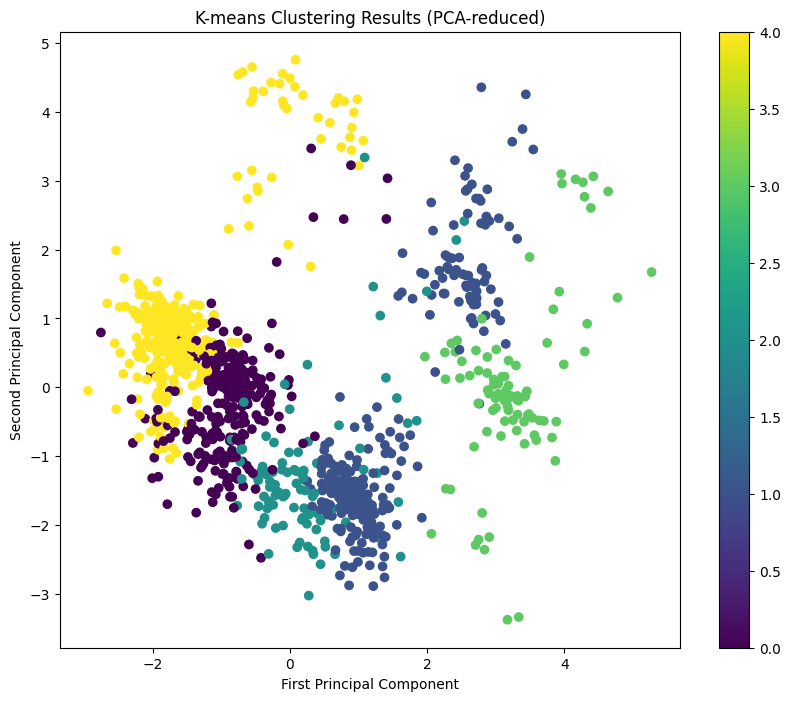

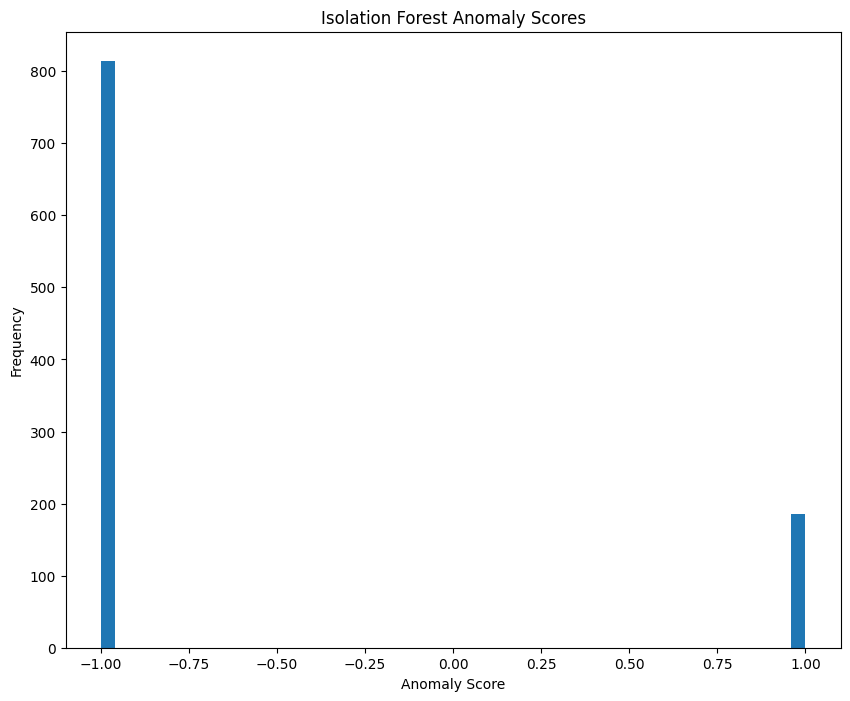

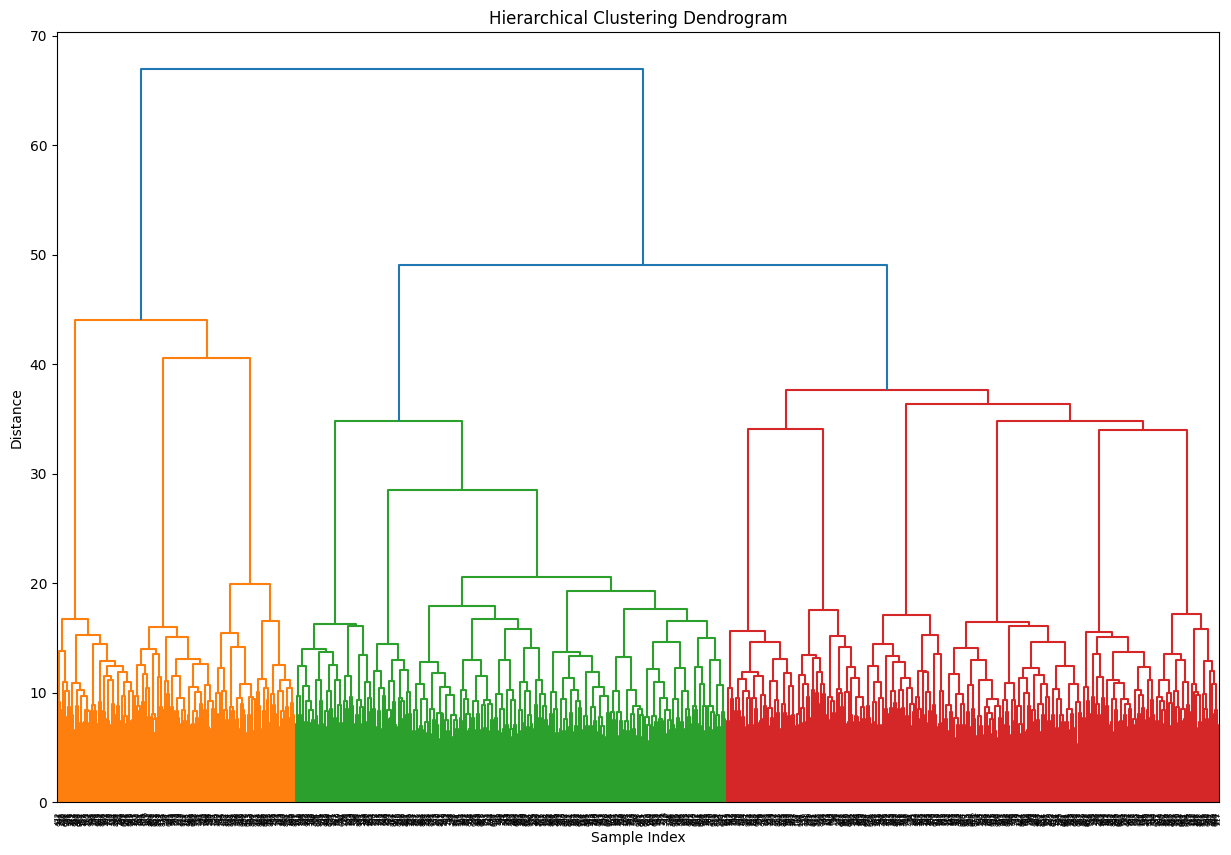

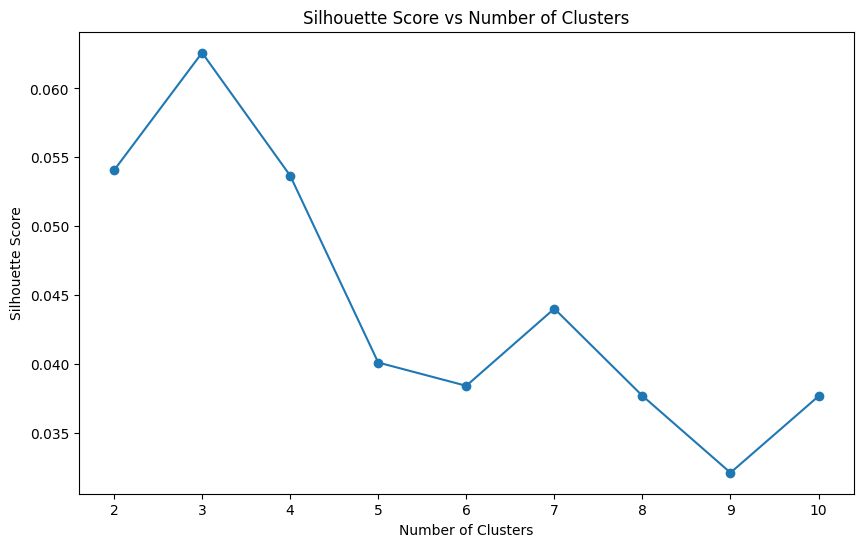


Running supervised analysis...

Analyzing results...
Top 10 configurations based on F1 score:
      feature_config       split              model  accuracy  precision  \
25               pca  time_50_50  gradient_boosting  0.908000   0.041667   
15               pca     loco_cv  gradient_boosting  0.936317   0.020833   
42  remove_collinear  time_50_50      random_forest  0.952000   0.000000   
47  remove_collinear  time_80_20      random_forest  0.965000   0.000000   
46  remove_collinear  time_80_20           logistic  0.960000   0.000000   
45  remove_collinear  time_80_20  gradient_boosting  0.955000   0.000000   
44  remove_collinear  time_50_50            xgboost  0.952000   0.000000   
43  remove_collinear  time_50_50                svm  0.952000   0.000000   
0           original     regular  gradient_boosting  0.910000   0.000000   
49  remove_collinear  time_80_20            xgboost  0.965000   0.000000   

      recall        f1   roc_auc  
25  0.041667  0.041667  0.427871 

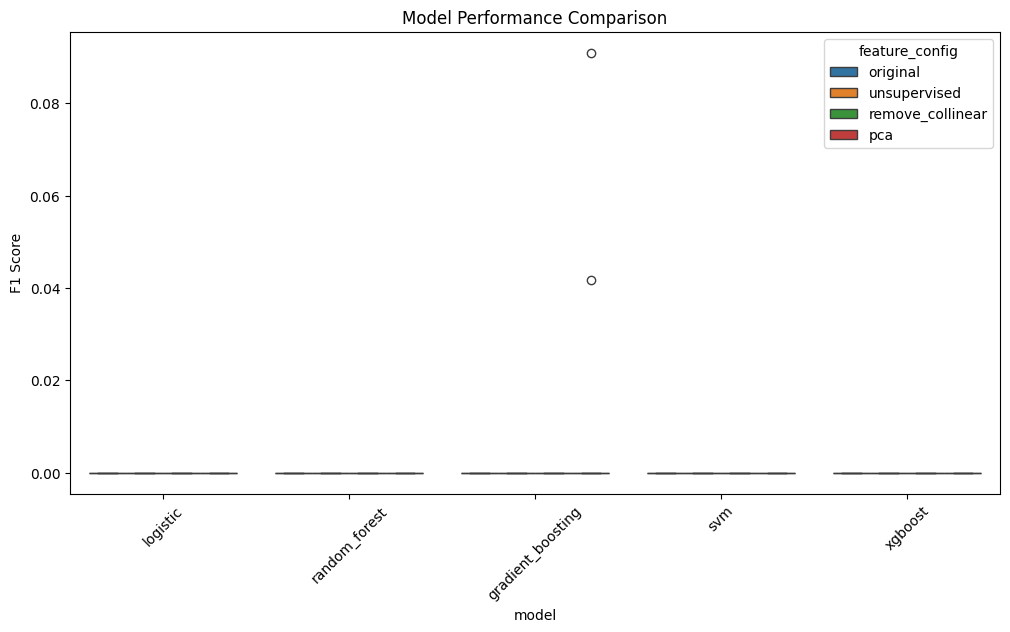

Regular Results:


,feature_config,split,model,accuracy,precision,recall,f1,f2,roc_auc,confusion_matrix
0,original,regular,logistic,0.9550,0.0,0.0,0.0,0.0,0.501966,"[[955, 0], [45, 0]]"
1,original,regular,random_forest,0.9550,0.0,0.0,0.0,0.0,0.502455,"[[955, 0], [45, 0]]"
2,original,regular,gradient_boosting,0.9530,0.0,0.0,0.0,0.0,0.569703,"[[953, 2], [45, 0]]"
3,original,regular,svm,0.9550,0.0,0.0,0.0,0.0,0.522978,"[[955, 0], [45, 0]]"
4,original,regular,xgboost,0.9550,0.0,0.0,0.0,0.0,0.479348,"[[955, 0], [45, 0]]"
5,original,time_50_50,logistic,0.9520,0.0,0.0,0.0,0.0,0.484443,"[[2380, 0], [120, 0]]"
6,original,time_50_50,random_forest,0.9520,0.0,0.0,0.0,0.0,0.477176,"[[2380, 0], [120, 0]]"
7,original,time_50_50,gradient_boosting,0.9484,0.0,0.0,0.0,0.0,0.486684,"[[2371, 9], [120, 0]]"
8,original,time_50_50,svm,0.9520,0.0,0.0,0.0,0.0,0.486310,"[[2380, 0], [120, 0]]"
9,original,time_50_50,xgboost,0.9520,0.0,0.0,0.0,0.0,0.495676,"[[2380, 0], [120, 0]]"


In [125]:
# Load your data
df = pd.read_csv("identity_fraud_data.csv")
df = df[0:1000]
df['fraud_cat1'] = np.random.choice(['A', 'B', 'C'], df.shape[0])
df['fraud_cat2'] = np.random.choice(['X', 'Y', 'Z'], df.shape[0])
threshold = df['fraud_probability'].quantile(0.95)  # Use 95th percentile as threshold
#df['fraud_cat1'] = np.random.choice([1,2,3], df.shape[0])
#df['fraud_cat2'] = np.random.choice([5,6,7], df.shape[0])

df['fraud_binary'] = (df['fraud_probability'] > threshold).astype(int)

config = AnalysisConfig(
    data_path="identity_fraud_data.csv",
    label_column="fraud_binary",  # This should be your continuous fraud probability column
    feature_columns=[col for col in df.columns if not col.startswith('heuristic') and col not in ['transaction_date', 'user_id', 'fraud_probability','fraud_cat1', 'fraud_cat2']],
    #heuristic_columns=[col for col in df.columns if col.startswith('heuristic')],
    loco_cv_columns=['fraud_cat1', 'fraud_cat2'],
    date_column='transaction_date',
    # test_size=0.2,
    # random_state=42,
    # variance_threshold=0.01,
    # correlation_threshold=0.95,
    # pca_n_components=0.95,
    # n_clusters=5
    #test_start_date="2023-07-01"
)
# model_config = ModelConfig()
# drift_config = DriftConfig()

# analyzer = FraudDetectionFramework(df, config, model_config, drift_config)
# analyzer.run_analysis()

analyzer = EnhancedFraudDetectionFramework(df, config)
results_df = analyzer.run_analysis()

print("Regular Results:")
display(regular_results_df)


